# Processing the IR dataset

In [1]:
from spectrochempy.api import *
options.log_level=ERROR

SpectroChemPy's API - v.0.1a5.dev
© Copyright 2014-2017 - A.Travert and C.Fernandez @ LCS


## loading a project

We read the 'HIZECOKE' project saved previously

In [2]:
proj = Project.load('HIZECOKE')
proj

Let's replot the data. For this we need to do again the previous pre-processing first.

<IPython.core.display.Javascript object>


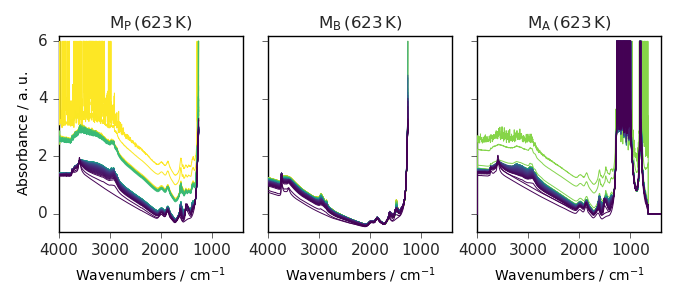

In [3]:
datasets =[]
labels = []

for p in reversed(proj.projects):   # we put the parent first this way
    datasets.append(p.IR)
    labels.append(p.label) 
    
_ = multiplot_stack(sources=datasets, labels=labels, 
                nrow=1, ncol=3, sharex=True, sharez=True, 
                figsize=(6.8,3), dpi=100, style='sans')

## Creating and using project's scripts

In order to avoid having to write this basic pre-processing and plotting function each time we read the initial project, there is two ways:

1. We can save the mofified data and reopen the project with the modified files next time we need them. However, the processing that was applied cannot be modified.
2. The second possibility is to save the processing scripts along with the project, and reapply them next time we will open this project. If a modification is required, any of the scripts can be modified before being applied.

it would be useful to keep the script used here along with the project.

To do so, we will store them in the project, using the `%addscript` magic function.

The syntax is simple!

There are two possibilities: 

1. `%addscript -p <project_name> -o <scriptname> <cell_reference, file or objects>`
1. `%%addscript -p <project_name> -o <scriptname>` 
    
        ...code lines...

where

* `-p <project_name>` to say in wich project we want to strore our script
* `-o <script_name>` to say which name will be used for that script. It must be unique in a project, or confusion may rapidly arise.

That's almost all:
* The script can come from the current cell (in this case modify the command like this: `%%addscript -p <project_name> -o <script_name>` (yes with two `%`). This should be the first line of the cell to use as a script. 
* it can also come from another already executed cell: inthis case with give the `id` (*e.g.,* `3`) of the cell to use or a range of cells to use (*e.g.,* `3-10`)


In [4]:
%addscript -p proj -o preprocess 3

"\ndatasets =[]\nlabels = []\n\nfor p in reversed(proj.projects):   # we put the parent first this way\n    datasets.append(p.IR)\n    labels.append(p.label) \n    \n_ = multiplot_stack(sources=datasets, labels=labels, \n                nrow=1, ncol=3, sharex=True, sharez=True, \n                figsize=(6.8,3), dpi=100, style='sans')\n"

In [5]:
%%addscript -p proj -o print_info

print("samples contained in the project are: %s"%proj.projects_names)


'\n\nprint("samples contained in the project are: %s"%proj.projects_names)'

Let's check that the script are stored in the project:

In [6]:
proj

In [9]:
proj.print_info()


 ERROR | TypeError: 'Script' object is not callable


In [ ]:
from IPython.core.magic import (Magics, magics_class, line_magic, cell_magic,
                                line_cell_magic)
from IPython.core.magics.code import extract_symbols
from IPython.core.error import UsageError
from IPython.utils.text import get_text_list

# ============================================================================
# Magic ipython function
# ============================================================================
@magics_class
class SpectroChemPyMagics2(Magics):

    @line_magic
    def runscript(self, pars=''):
        """
        
        """
        opts, args = self.parse_options(pars, '')
        
        if not args:
            raise UsageError('Missing script name')
    
        return args

In [ ]:
%execute

In [ ]:
def add_script(priority=50):

    def decorator(func):

        def wrapper(*args, **kwargs):
            print('ok', priority)
            return func(*args, **kwargs)
        return wrapper

    return decorator
    

In [ ]:
@add_script(priority=0)    # priority 0, it will be executed after all other scripts
def plot_IR(proj, figsize=(6.8,3), dpi=100, style='sans') :
    datasets =[]
    labels = []
    for p in reversed(proj.projects):   # we put the parent first this way
        p.IR[:, 3998.:1295., INPLACE]      # let's keep only the usefull region
        datasets.append(p.IR)
        labels.append(p.label) 
        
    multiplot_stack(sources=datasets, labels=labels, 
                nrow=1, ncol=3, sharex=True, sharez=True, 
                figsize=figsize, dpi=dpi, style=style)
    return None

In [ ]:
options.log_level=WARNING
plot_IR(proj)

## Masking bad data

Clearly some of the spectra above displayed have problem with noise, or some experiment artifacts. Let's mask them. 

First, we will make a copy of the data, to be sure not to modified them before finishing alll the processing.

Then, we will select the region of interest.

###  Some notes about Slicing

Slicing can be done by index, coordinates or labels (when they are present).

* `P350[:, 10]` for colomn slicing (here we get the 10th column (with index starting at 0!))
* or `P350[10]` for row slicing

As said above, we can also slice using the real coordinates. For example,

* `P350[:, 3000.0:3100.0]` will select all columns from wavenumbers 3000 to 3100. 

**IMPORTANT** : when doing such slicing, the wavenumbers must be expressed as floating numbers (with the decimal separator present) or it will fail!.

Here we want to leave only a selection of wavenumbers (between 4000. and 1290. cm$^{-1}$). Let's try to mask them. It is just necessary to affect the value **`masked`** to the data we want to mask:



In [ ]:
for key, sample in samples.items():
    sample['IR'][:,400.:1290.] = masked 
    

Here we have masked the undesired data using coordinates slicing. However, note that when using coordinates, both limits needs to be set, as SpectroChemPy cannot infer wich direction will be masked)

Let's display the results

In [ ]:
sources = [sample['IR'] for sample in samples.values()]
labels = ["sample "+sample['label'] for sample in samples.values()]

_ = multiplot_stack(sources=sources, labels=labels, nrow=1, ncol=3, figsize=(9,4), sharex=False,
                sharey=True, style='sans')

To remove a mask, the only way is to remove **all** masks. It cannot be done selectively!

In [ ]:
for key, sample in samples.items():
    sample['IR'].remove_masks()

_ = multiplot_stack(sources=sources, labels=labels, nrow=1, ncol=3, figsize=(9,4), sharex=False,
                sharey=True, style='sans')

Actually, because we want to select a region of interest, it might be simple to just keep this region (no need to use masks for this). WE will slice this and stor this for further use.

In [ ]:
for key, sample in samples.items():
    s = sample['IR'][:,1290.:4000.]  # such slicing is not done inplace. Original data are preserved.
    sample['IR'] = s                 # we thus need to force the change to keep this modification in the
                                     # original data.
        
    # save the data in a `scp` file
    basename = os.path.join(scpdata,'agirdata/{}/FTIR/FTIR'.format(key))
    sample['IR'].save(basename + '_corrected.scp')

### Masking bad data for sample P350

May be, besides just slicing as above explained, it is useful to use the an interactive window to mask some values. Also because, it appears that mainly the data to remove correspond to some row it may be interesting to work on transposed data (we use the operator `.T`):

In [ ]:
P350T = samples['P350']['IR'].T
_ = P350T.interactive_masks(figsize=(9,5))

In [ ]:
P350T.T.plot_stack()
# keep this 
P350 = P350T.T

Put back the masked data into the original

In [ ]:
samples['P350']['IR'] = P350 

### Masking bad data for sample A350

Again we will work on transposed data

In [ ]:
A350T= samples['A350']['IR'].T
A350T.interactive_masks(figsize=(9,5))

In [ ]:
samples

In [ ]:
samples['P350']['IR']

In [ ]:
samples['P350']['IR'].plot()

In [ ]:
import re
p = re.compile(r"^[^\W0-9]?[a-zA-Z_]+[\w]*\b")
p.match('name.x')[0]